In [3]:
import io
import os
import pickle
import requests
import numpy as np
import pandas as pd
from actsnfink import *
from shutil import copy
from copy import deepcopy
from astropy.time import Time
import matplotlib.pylab as plt
from distutils.dir_util import copy_tree
from sklearn.ensemble import RandomForestClassifier
from actsnclass.metrics import get_snpcc_metric
from actsnclass.metrics import get_snpcc_metric

In [4]:
fink_colors_list = ['#15284F','#F5622E','#D5D5D3','#3C8DFF']

# Initial configuration

In [5]:
train_first_model = False
strategy = 'UncSampling'            # query strategy

In [6]:
def plot_lc(list_lc,dir_suffix):
    fig = plt.figure(figsize=(12, 6))

    # Colors to plot
    colordic = {1: 'C0', 2: 'C1'}

    # Labels of ZTF filters
    filtdic = {1: 'g', 2: 'r'}

    for filt in filtdic.keys():
        jd = lc.cjd[0][np.where(lc.cfid[0]==filt)[0]] - 2400000.5
        mag = lc.cmagpsf[0][np.where(lc.cfid[0]==filt)[0]]
        emag = lc.csigmapsf[0][np.where(lc.cfid[0]==filt)[0]]
        plt.errorbar(
            jd,
            mag,
            emag,
            ls = '', marker='o', color=colordic[filt], label=filtdic[filt]
        )


    plt.gca().invert_yaxis()
    # plt.legend()
    plt.title(f"{str(list_lc['objectId'][0])} TNS: {str(list_lc['TNS'][0])}")
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')

    outdir = f'../plots/train_lcs_{dir_suffix}' if dir_suffix!="" else '../plots/train_lcs'
    
    os.makedirs(outdir, exist_ok=True)
    
    plt.savefig(f"{outdir}/{list_lc['objectId'][0]}")

In [18]:
def AL_loop(new_labels, train_for_loop, dir_suffix ="", proba_cut = True, plot_lcs=False):

    dir_output= f'../data_{dir_suffix}/' if dir_suffix!="" else  '../data/'

    if not os.path.exists(f"{dir_output}/initial_state"):
        print("No path",f"{dir_output}/initial_state")
        os.makedirs(dir_output, exist_ok=True)
        # copy initial state
        copy_tree("../data/initial_state", f"{dir_output}/initial_state")
    
    time_counter = 0
    metrics_all_list = []
    probabilities_list = []

    for d, date in enumerate(list(new_labels.keys())):
    
        print(date)
        
        # read previous training sample and trained model
        if date == list(new_labels.keys())[0]:
            train_for_loop = pd.read_csv(dir_output + 'initial_state/' + strategy + \
                                               '/training_samples/train_after_loop.csv', 
                                               index_col=False)
            
            clf_before = pickle.load(open(dir_output + 'initial_state/' + strategy + \
                                               '/models/model.pkl', 'rb'))
        else:
            is_file = False
            indx = list(new_labels.keys()).index(date) - 1
            
            while not is_file and indx >= 0:
                
                date_before = list(new_labels.keys())[indx]
                is_file = os.path.isfile(dir_output + date_before + \
                                              '/' + strategy  + \
                                              '/training_samples/train.csv')
                if is_file:
                    train_for_loop = pd.read_csv(dir_output +  date_before + \
                                              '/' + strategy  + \
                                              '/training_samples/train.csv', 
                                              index_col=False)    
            
                    clf_before = pickle.load(open(dir_output +  date_before + '/' + strategy + \
                                               '/models/model.pkl', 'rb'))
                else:
                    indx = indx - 1
    
        ########################################################################
        ### create directory structure
        dirname_output = dir_output +  date + '/'
        
        for name in [dirname_output + '/', 
                     dirname_output + '/' + strategy + '/', 
                     dirname_output + '/' + strategy + '/models/', 
                     dirname_output + '/' + strategy + '/class_prob/',
                     dirname_output + '/' + strategy + '/metrics/', 
                     dirname_output + '/' + strategy + '/queries/',
                     dirname_output + '/' + strategy + '/training_samples/', 
                     dirname_output + '/' + strategy + '/test_samples/']:
            if not os.path.isdir(name):
                os.makedirs(name)
    
        #######################################################################
        ### Get alert data
        
        alerts_list = []
    
        for i in range(new_labels[date].shape[0]):
            
            name = new_labels[date][i][0]
            # print(name)
    
            r = requests.post(
                'https://fink-portal.org/api/v1/objects',
                json={
                    'objectId':name,
                    'output-format': 'json'
                }
            )

            try:
                # Format output in a DataFrame
                pdf = pd.read_json(io.BytesIO(r.content))
            except Exception:
                pdf= pd.DataFrame()
    
            if pdf.shape[0] == 0:
                print(f"No alerts found for object: {name}")
                # raise ValueError('No alerts found for object: ', name)
            else:
                # add label
                pdf['type'] = new_labels[date][i][1] 
        
                alerts_list.append(pdf)
    
        if len(alerts_list)>0:
            alerts_pd = pd.concat(alerts_list, ignore_index=True)
        
        
            #############################################################################
            #### feature extract for each date
            
            alerts_format_list = []
        
            for indx_obj in range(new_labels[date].shape[0]):
                
                # isolate one object
                flag_obj = alerts_pd['i:objectId'].values == new_labels[date][indx_obj][0]
        
                # separate only dates until the alert was sent to follow-up
                cjd = alerts_pd[flag_obj]['i:jd'].values
                flag_jd = cjd < float(new_labels[date][indx_obj][2])

                # for ZTF, some light-curves were not available before classification
                if len(alerts_pd[flag_obj]['i:jd'].values[flag_jd])>0: 
                    
                    #flag_jd = np.array([True for i in range(cjd.shape[0])])
                    lc = pd.DataFrame([[new_labels[date][indx_obj][0], 
                                    alerts_pd[flag_obj]['i:candid'].values[flag_jd][np.argsort(alerts_pd[flag_obj]['i:jd'].values[flag_jd])[-1]],
                                    alerts_pd[flag_obj]['i:jd'].values[flag_jd],         
                                    alerts_pd[flag_obj]['i:fid'].values[flag_jd], 
                                    alerts_pd[flag_obj]['i:magpsf'].values[flag_jd],
                                    alerts_pd[flag_obj]['i:sigmapsf'].values[flag_jd],
                                    new_labels[date][indx_obj][1]]], 
                                    columns=['objectId', 'candid', 'cjd', 'cfid', 'cmagpsf', 'csigmapsf', 'TNS'], index=[0], dtype=object)
                
                    alerts_format_list.append(lc)
                    
                    if plot_lcs:
                        plot_lc(lc)
                        
            if len(alerts_format_list)>0:
                alerts_format_pd = pd.concat(alerts_format_list, ignore_index=True)
            
                
                # convert from mag to FLUXCAL
                alerts_flux = convert_full_dataset(alerts_format_pd, obj_id_header='objectId')
            
                # extract features
                alerts_features = featurize_full_dataset(alerts_flux, screen=False,
                                                         ewma_window=3, 
                                                          min_rising_points=1, 
                                                          min_data_points=3, rising_criteria='ewma')
            
            
            
                # filter alerts with zero in all filters
                flag_zero = np.logical_and(alerts_features['a_g'].values == 0.0,
                                           alerts_features['a_r'].values == 0.0)
                # flag_zero = np.logical_or(alerts_features['a_g'].values == 0.0,
                #                            alerts_features['a_r'].values == 0.0)
            
                alerts_use = deepcopy(alerts_features[~flag_zero])
                # print('    alerts_use.shape = ', alerts_use.shape)
            
                # go through events if they have at least one band with features
                if alerts_use.shape[0] > 0:
                    alerts_use.rename(columns={'id':'objectId'}, inplace=True)
                    alerts_use['loop'] = list(new_labels.keys()).index(date) + 30
                
                    # see what current model says about queried alerts
                    pred_prob_query = clf_before.predict_proba(alerts_use[list(alerts_use.keys())[2:-1]])
                    # print(f'Proba {pred_prob_query}')
        
                    if proba_cut:
                        keep_index = []
                        for j in range(len(pred_prob_query)):
                            if (pred_prob_query[j][0]>0.4) & (pred_prob_query[j][0]<0.6):
                                keep_index.append(j)
                        new_alerts_use = alerts_use.iloc[keep_index]
                        probabilities_list.append(pred_prob_query[j][0])
                    else:
                        new_alerts_use = alerts_use
                        probabilities_list.append(pred_prob_query)
            
                    if len(new_alerts_use) > 0:
                                              
                        # update training
                        train_updated = pd.concat([train_for_loop, new_alerts_use], ignore_index=True)
                        print('    train_updated.shape = ', train_updated.shape)
            
                        # save to file
                        train_updated.to_csv(dir_output + date +'/' + strategy  + \
                                                          '/training_samples/train.csv', 
                                                           index=False)
                    
                        # train model
                        clf = RandomForestClassifier(random_state=42, n_estimators=1000)
                        clf.fit(train_updated[list(train_updated.keys())[:-3]], 
                                    train_updated['type'].values == 'Ia')
                    
                        # make predictions
                        pred = clf.predict(test_for_loop[list(test_for_loop.keys())[:-2]])
                        pred_prob = clf.predict_proba(test_for_loop[list(test_for_loop.keys())[:-2]])
                        
                        # save mode
                        pickle.dump(clf, open(dir_output + date + '/' + strategy + '/models/model.pkl', 
                                                  'wb'))
                    
                        # save predictions
                        pred_prob_pd = pd.DataFrame(np.hstack([test_for_loop['objectId'].values.reshape(-1,1), 
                                                        np.array(pred_prob[:,1]).reshape(-1,1)]), 
                                                        columns=['objectId','probIa'])
                        pred_prob_pd.to_csv(dir_output +  date + '/' + strategy + \
                                            '/class_prob/test_class_prob.csv', index=False)
                
                        # calculate metrics
                        names, res = get_snpcc_metric(pred, test_for_loop['type'].values == 'Ia')
                        # print('   res = ', res)
                        
                        metric_pd = pd.DataFrame([[date] + [list(new_labels.keys()).index(date) + 30] + res + \
                                                     [list(alerts_use['objectId'].values)]],
                                                    columns=['date','loop'] + names + ['query_objectIds'])
                        metric_pd.to_csv(dir_output +  date +'/' + strategy  + \
                                                          '/metrics/metric.csv', 
                                                           index=False)
                        metric_pd['date_plot'] = d 
                        metrics_all_list.append(metric_pd)
                        
    if len(metrics_all_list)>0:        
        metrics = pd.concat(metrics_all_list, ignore_index=True)
        metrics['n spectra']= metrics['query_objectIds'].apply(lambda x: len(x)).cumsum()

    else:
        metrics = pd.DataFrame()

    return metrics, probabilities_list

In [8]:
# read train and test data for loop
train_for_loop = pd.read_csv( '../data/initial_state/' + strategy + \
                                           '/training_samples/train_after_loop.csv', 
                                           index_col=False)

test_for_loop = pd.read_csv('../data/initial_state/' + strategy + \
                                           '/test_samples/test_after_loop.csv', 
                                           index_col=False)

In [9]:
print(f"Number of training light-curves {len(train_for_loop)}")

Number of training light-curves 40


In [12]:
train_for_loop.groupby('type').count()['c_g']

type
AGN         1
C*          2
EB*         3
Ia         13
Mira        1
QSO         7
RRLyr       4
SLSN-I      1
SNII        3
SNIIP       1
SNIIn       1
SNIb        1
Star        1
Varstar     1
Name: c_g, dtype: int64

In [13]:
test_for_loop['type'].unique()
type_list = ['SN','SNII','Ia', 'SLSN-I','SNIIP', 'SNIIn', 'SLSN-II', 'SNIc', 'SNIb', 'SNIIb', 'SNI','SNIb-pec', 'SNIc-BL','SNII-pec','SNIbn']
test_for_loop = test_for_loop[test_for_loop['type'].isin(type_list)]

In [14]:
# train initial model
clf = RandomForestClassifier(random_state=42, n_estimators=1000)
clf.fit(train_for_loop[list(train_for_loop.keys())[:-3]], train_for_loop['type'].values == 'Ia')

RandomForestClassifier(n_estimators=1000, random_state=42)

In [15]:
# make predictions
pred = clf.predict(test_for_loop[list(test_for_loop.keys())[:-2]])
pred_prob = clf.predict_proba(test_for_loop[list(test_for_loop.keys())[:-2]])

# calculate metrics
get_snpcc_metric(pred, test_for_loop['type'].values == 'Ia')

(['accuracy', 'efficiency', 'purity', 'fom'],
 [np.float64(0.4739316239316239),
  np.float64(0.26212980466288593),
  np.float64(0.8739495798319328),
  np.float64(0.18296308513382645)])

In [16]:
# save mode
pickle.dump(clf, open('../data/initial_state/' + strategy + '/models/model.pkl', 
                      'wb'))

In [17]:
# labels from 2.3m SSO, Australia
# here I used the date one day after it was sent to make sure to include all points regardless
# of when the night started

new_labels = {}
new_labels['20230921'] = np.array([['ZTF23abecphw', 'other', Time('2023-09-25', format='iso').jd]]) #AM why 25 vs 21?
new_labels['20230925'] = np.array([['ZTF23abdhvou', 'Ia', Time('2023-09-26', format='iso').jd]])
new_labels['20230928'] = np.array([['ZTF23abceaws', 'other', Time('2023-10-01', format='iso').jd]])
new_labels['20231005'] = np.array([['ZTF23abhtkba', 'other', Time('2023-10-06', format='iso').jd],
                                   ['ZTF23abeudve', 'Ia', Time('2023-10-06', format='iso').jd],
                                   ['ZTF23abggbdy', 'Ia', Time('2023-10-06', format='iso').jd]])
new_labels['20231006'] = np.array([['ZTF23abghfyg', 'Ia', Time('2023-10-07', format='iso').jd]])
new_labels['20231009'] = np.array([['ZTF23abhafym', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abgspys', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abglsmj', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abgfwhj', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abhublj', 'Ia', Time('2023-10-10', format='iso').jd]])
new_labels['20231013'] = np.array([['ZTF23abgspvs', 'Ia', Time('2023-10-14', format='iso').jd],
                                   ['ZTF23abgnfdv', 'Ia', Time('2023-10-14', format='iso').jd],
                                  ['ZTF23abhzwll', 'Ia', Time('2023-10-14', format='iso').jd]])
new_labels['20231015'] = np.array([['ZTF23abhailb', 'other', Time('2023-10-16', format='iso').jd]])
                                  # ['ZTF23abgfwhj', 'Ia', Time('2023-10-16', format='iso').jd]])
new_labels['20231016'] = np.array([['ZTF23abihzbq', 'Ia', Time('2023-10-17', format='iso').jd]])
new_labels['20231018'] = np.array([['ZTF23abhvsbo', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abiljba', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abhzlbh', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abixwfv', 'other', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abidsaw', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abhzoyw', 'Ia', Time('2023-10-19', format='iso').jd]])
new_labels['20231019'] = np.array([['ZTF23abkavcl', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abjzkqu', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abkgdei', 'Ia', Time('2023-10-20', format='iso').jd],
                                   # ['ZTF23abidmwl', 'other', Time('2023-10-20', format='iso').jd],
                                  ['ZTF23abjhbcr', 'other', Time('2023-10-20', format='iso').jd]])
new_labels['20231022'] = np.array([['ZTF23abjtozz', 'Ia', Time('2023-10-23', format='iso').jd]])
new_labels['20240224'] = np.array([['ZTF24aaejkyp', 'other', Time('2024-02-25', format='iso').jd]])
new_labels['20240229'] = np.array([['ZTF24aaegskb', 'Ia', Time('2024-03-01', format='iso').jd]])
new_labels['20240404'] = np.array([['ZTF24aahgtjt', 'Ia', Time('2024-04-05', format='iso').jd]])
new_labels['20240405'] = np.array([['ZTF24aahgqwk', 'other', Time('2024-04-06', format='iso').jd]])
new_labels['20240409'] = np.array([['ZTF24aahznij', 'Ia', Time('2024-04-10', format='iso').jd],
                                  ['ZTF24aahuulq', 'Ia', Time('2024-04-10', format='iso').jd]])
new_labels['20240410'] = np.array([['ZTF24aaiftcp', 'Ia', Time('2024-04-11', format='iso').jd],
                                  ['ZTF24aaiehwu', 'Ia', Time('2024-04-11', format='iso').jd]])
new_labels['20240412'] = np.array([['ZTF24aaindpx', 'Ia', Time('2024-04-13', format='iso').jd]])
new_labels['20240413'] = np.array([['ZTF24aaiypmp', 'Ia', Time('2024-04-14', format='iso').jd]])
new_labels['20240414'] = np.array([['ZTF24aahtdhb', 'other', Time('2024-04-15', format='iso').jd]]) #AM
new_labels['20240417'] = np.array([['ZTF24aaieino', 'Ia', Time('2024-04-18', format='iso').jd],])
                                  # ['ZTF24aahznij', 'Ia', Time('2024-04-18', format='iso').jd]]) # already in previous days
new_labels['20240418'] = np.array([['ZTF24aaiigrt', 'Ia', Time('2024-04-21', format='iso').jd],
                                  ['ZTF24aaiafkl', 'other', Time('2024-04-19', format='iso').jd]])
new_labels['20240421'] = np.array([['ZTF24aaikjjk', 'other', Time('2024-04-22', format='iso').jd]])
new_labels['20240423'] = np.array([['ZTF24aajqamj', 'other', Time('2024-04-24', format='iso').jd]])
new_labels['20240503'] = np.array([['ZTF24aajwajo', 'other', Time('2024-05-04', format='iso').jd],
                                  ['ZTF24aajqwsm', 'Ia', Time('2024-05-04', format='iso').jd]])
new_labels['20240504'] = np.array([['ZTF24aakfchb', 'other', Time('2024-05-05', format='iso').jd]])
new_labels['20240505'] = np.array([['ZTF24aakymro', 'Ia', Time('2024-05-06', format='iso').jd]])
new_labels['20240507'] = np.array([['ZTF24aalhjeu', 'other', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalhjml', 'Ia', Time('2024-05-08', format='iso').jd],
                                   ['ZTF24aalsuwb', 'Ia', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalcflg', 'Ia', Time('2024-05-08', format='iso').jd],
                                   ['ZTF24aalpgky', 'other', Time('2024-05-08', format='iso').jd]])
new_labels['20240508'] = np.array([['ZTF24aakyqxt', 'Ia', Time('2024-05-09', format='iso').jd],
                                   ['ZTF24aalbzkr', 'Ia', Time('2024-05-09', format='iso').jd]])
new_labels['20240510'] = np.array([['ZTF24aalbkdo', 'Ia', Time('2024-05-11', format='iso').jd]])
new_labels['20240514'] = np.array([['ZTF24aamtsgz', 'Ia', Time('2024-05-15', format='iso').jd]])
new_labels['20240515'] = np.array([['ZTF24aamdfll', 'Ia', Time('2024-05-16', format='iso').jd]])
new_labels['20240521'] = np.array([['ZTF24aaomuhe', 'Ia', Time('2024-05-22', format='iso').jd]])
new_labels['20240601'] = np.array([['ZTF24aaoxbth', 'Ia', Time('2024-06-02', format='iso').jd]])
new_labels['20240622'] = np.array([['ZTF24aarfccy', 'Ia', Time('2024-06-23', format='iso').jd]])
new_labels['20240623'] = np.array([['ZTF24aarwwnc', 'other', Time('2024-06-24', format='iso').jd]])
new_labels['20240624'] = np.array([['ZTF24aasfxgh', 'Ia', Time('2024-06-25', format='iso').jd]])
new_labels['20240627'] = np.array([['ZTF24aaqutdf', 'other', Time('2024-06-28', format='iso').jd]])
new_labels['20240628'] = np.array([['ZTF24aasmghi', 'Ia', Time('2024-06-29', format='iso').jd]])
new_labels['20240703'] = np.array([['ZTF24aatkrrw', 'other', Time('2024-07-04', format='iso').jd]])
new_labels['20240706'] = np.array([['ZTF24aatfxrw', 'Ia', Time('2024-07-07', format='iso').jd]])



In [102]:
metrics_fink_all, probabilities_list_all = AL_loop(new_labels, train_for_loop, dir_suffix ="", proba_cut = False, plot_lcs=False)

20230921
    train_updated.shape =  (41, 15)
20230925
    train_updated.shape =  (42, 15)
20230928
20231005
    train_updated.shape =  (45, 15)
20231006
    train_updated.shape =  (46, 15)
20231009
    train_updated.shape =  (50, 15)
20231013
    train_updated.shape =  (53, 15)
20231015
    train_updated.shape =  (54, 15)
20231016
    train_updated.shape =  (55, 15)
20231018
    train_updated.shape =  (60, 15)
20231019
    train_updated.shape =  (64, 15)
20231022
    train_updated.shape =  (65, 15)
20240224
    train_updated.shape =  (66, 15)
20240229
    train_updated.shape =  (67, 15)
20240404
    train_updated.shape =  (68, 15)
20240405
    train_updated.shape =  (69, 15)
20240409
    train_updated.shape =  (71, 15)
20240410
    train_updated.shape =  (73, 15)
20240412
    train_updated.shape =  (74, 15)
20240413
20240414
    train_updated.shape =  (75, 15)
20240417
    train_updated.shape =  (76, 15)
20240418
    train_updated.shape =  (78, 15)
20240421
    train_updated.shape =  (

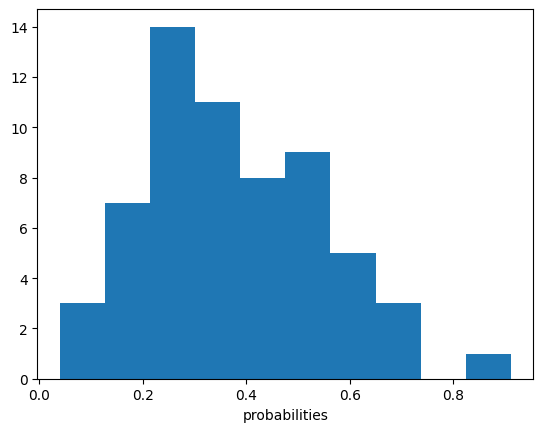

In [58]:
probabilities_fink = [k[0] for k in np.concatenate(probabilities_list_all)]
plt.hist(probabilities_fink)
plt.xlabel('probabilities')
plt.savefig('../data/probabilities.png')

In [22]:
metrics_fink_all.to_csv('../data/' + 'metrics.csv', index=False)

# Fink all + Probability cut

In [23]:
metrics_fink_probacut, probabilities_list_probacut = AL_loop(new_labels, train_for_loop, dir_suffix='probacut', proba_cut = True)

20230921
20230925
    train_updated.shape =  (42, 15)
20230928
20231005
20231006
20231009
    train_updated.shape =  (47, 15)
20231013
    train_updated.shape =  (50, 15)
20231015
20231016
20231018
    train_updated.shape =  (57, 15)
20231019
20231022
    train_updated.shape =  (61, 15)
20240224
20240229
20240404
20240405
    train_updated.shape =  (66, 15)
20240409
20240410
    train_updated.shape =  (67, 15)
20240412
20240413
20240414
20240417
20240418
    train_updated.shape =  (69, 15)
20240421
    train_updated.shape =  (70, 15)
20240423
20240503
20240504
    train_updated.shape =  (72, 15)
20240505
20240507
    train_updated.shape =  (73, 15)
20240508
20240510
20240514
20240515
20240521
20240601
20240622
20240623
20240624
20240627
20240628
20240703
20240706


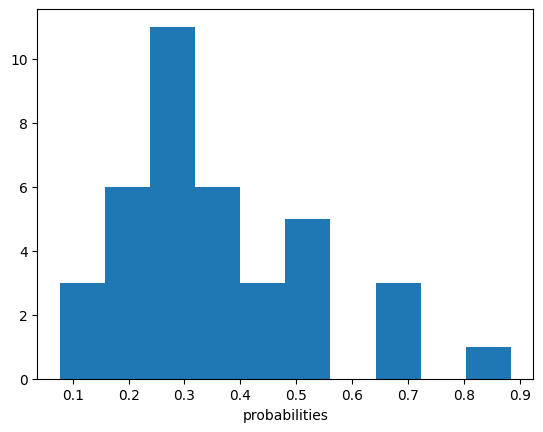

In [59]:
# probabilities_list_allprobacut_flat = np.concatenate(probabilities_list_probacut).ravel().tolist()
probabilities_fink_probacut = [k for k in probabilities_list_probacut]
plt.hist(probabilities_fink_probacut)
plt.xlabel('probabilities')
plt.savefig('../data_probacut/probabilities.png')

# With spec classified by ZTF


is it a good comaprisson by date? because there is a lot mroe spectra here, so maybe a fairer comparison is by number of spectra added.... but lets see the results.

In [27]:
# Function to convert Time object to desired format
from astropy.time import TimeDelta
def add_days_and_format(x,days):
    # Convert Time object to datetime
    time_obj = Time(x, format='iso') + TimeDelta(days, format='jd')
    dt = time_obj.datetime 
    # dt = time_obj.datetime
    # Format datetime to custom format
    return f"{dt.year}{dt.month:02d}{dt.day:02d}"

In [28]:
tmp1= pd.read_csv('../tns/tns-ZTFfoundandclassed_20230921_20231020.csv')
tmp2 = pd.read_csv('../tns/tns-ZTFfoundandclassed_20240216_20240230.csv')
tmp3 = pd.read_csv('../tns/tns-ZTFfoundandclassed_20240424_20240629.csv')

tmp = pd.concat([tmp1,tmp2,tmp3],ignore_index=True)
tmp['type'] = tmp['Obj. Type'].str.strip('SN ')
tmp['type AL'] = tmp['type'].apply(lambda x: 'Ia' if 'Ia' in x else 'other')
tmp['discoveryjd'] = [Time(d, format='iso').jd for d in tmp['Discovery Date (UT)']]
tmp['discoveryjd+12'] = tmp['discoveryjd'].apply(lambda x: int(x+12)) # 12 dayas as time to get ~3 measurements in each band
tmp['discoveryjd+12_strfmt'] = tmp['Discovery Date (UT)'].apply(lambda x: add_days_and_format(x, 12))

In [29]:
ztf_tns = tmp[['Disc. Internal Name','type AL','discoveryjd+12','discoveryjd+12_strfmt']]

In [33]:
print(f"Number of ZTF spectra available in this time frame {len(ztf_tns)}")

Number of ZTF spectra available in this time frame 157


In [34]:
# convert to new_labels format
dic_ztf_labels = {}
for dat in ztf_tns['discoveryjd+12'].unique():
    sel = ztf_tns[ztf_tns['discoveryjd+12']==dat]
    tmp_arr = sel[['Disc. Internal Name','type AL','discoveryjd+12']].to_numpy()

    date_in_str_fmt = sel['discoveryjd+12_strfmt'].values[0]
    dic_ztf_labels[date_in_str_fmt] = tmp_arr

In [35]:
metrics_ztf, probabilities_list_ztf = AL_loop(dic_ztf_labels, train_for_loop, dir_suffix='ZTF', proba_cut = False)

20231025
    train_updated.shape =  (41, 15)
20231006
20231017
20231027
    train_updated.shape =  (44, 15)
20231021
    train_updated.shape =  (45, 15)
20231016
    train_updated.shape =  (46, 15)
20240706
20240707
    train_updated.shape =  (47, 15)
20240708
No alerts found for object: ZTF24aatbpbr
No alerts found for object: ZTF24aatbpbr
20240627
    train_updated.shape =  (48, 15)
20240624
    train_updated.shape =  (49, 15)
20240621
    train_updated.shape =  (51, 15)
20240622
    train_updated.shape =  (52, 15)
20240619
    train_updated.shape =  (54, 15)
20240620
    train_updated.shape =  (55, 15)
20240614
20240613
    train_updated.shape =  (56, 15)
20240609
20240612
20240611
20240610
20240606
20240607
20240528
No alerts found for object: ZTF24aaoasjl
No alerts found for object: ZTF24aaoasjl
20240530
20240602
20240601
20240529
20240526
20240527
20240525
20240523
    train_updated.shape =  (58, 15)
20240519
No alerts found for object: ZTF24aalqrpc
No alerts found for object: ZT

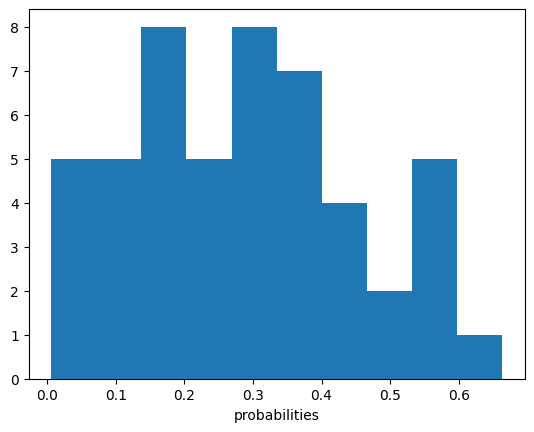

In [64]:
probabilities_ZTF = [k[0] for k in np.concatenate(probabilities_list_ztf)]
plt.hist(probabilities_ZTF)
plt.xlabel('probabilities')
plt.savefig('../data_ZTF/probabilities.png')

In [66]:
print('Comparing how many spectra are available in the different samples')
print(f'ZTF {len(probabilities_ZTF)}')
print(f'Fink {len(probabilities_fink)}')
print(f'Fink prob {len(probabilities_fink_probacut)}')

Comparing how many spectra are available in the different samples
ZTF 50
Fink 61
Fink prob 38


In [75]:
def plot_metrics_listdf(list_df,label_list,plots_dir='./', varx='date_plot',suffix=''):
    plt.figure(figsize=(16,10))
    
    for i,df in enumerate(list_df):

        color_to_use = fink_colors_list[i]
        xlabel = 'date' if varx=='date_plot' else varx
        
        plt.subplot(2,2,1)
        plt.scatter(df[varx].astype(int), df['accuracy'],label=label_list[i],color=color_to_use)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel('accuracy')
        
        plt.subplot(2,2,2)
        plt.scatter(df[varx].astype(int), df['efficiency'],color=color_to_use)
        plt.xlabel(xlabel)
        plt.ylabel('efficiency')
        
        plt.subplot(2,2,3)
        plt.scatter(df[varx].astype(int), df['purity'],color=color_to_use)
        plt.xlabel(xlabel)
        plt.ylabel('purity')
        
        plt.subplot(2,2,4)
        plt.scatter(df[varx].astype(int), df['fom'],color=color_to_use)
        plt.xlabel(xlabel)
        plt.ylabel('figure of merit')

    
    plt.savefig(f'{plots_dir}/metrics_superposed_{varx}{suffix}.png')    
    plt.show()

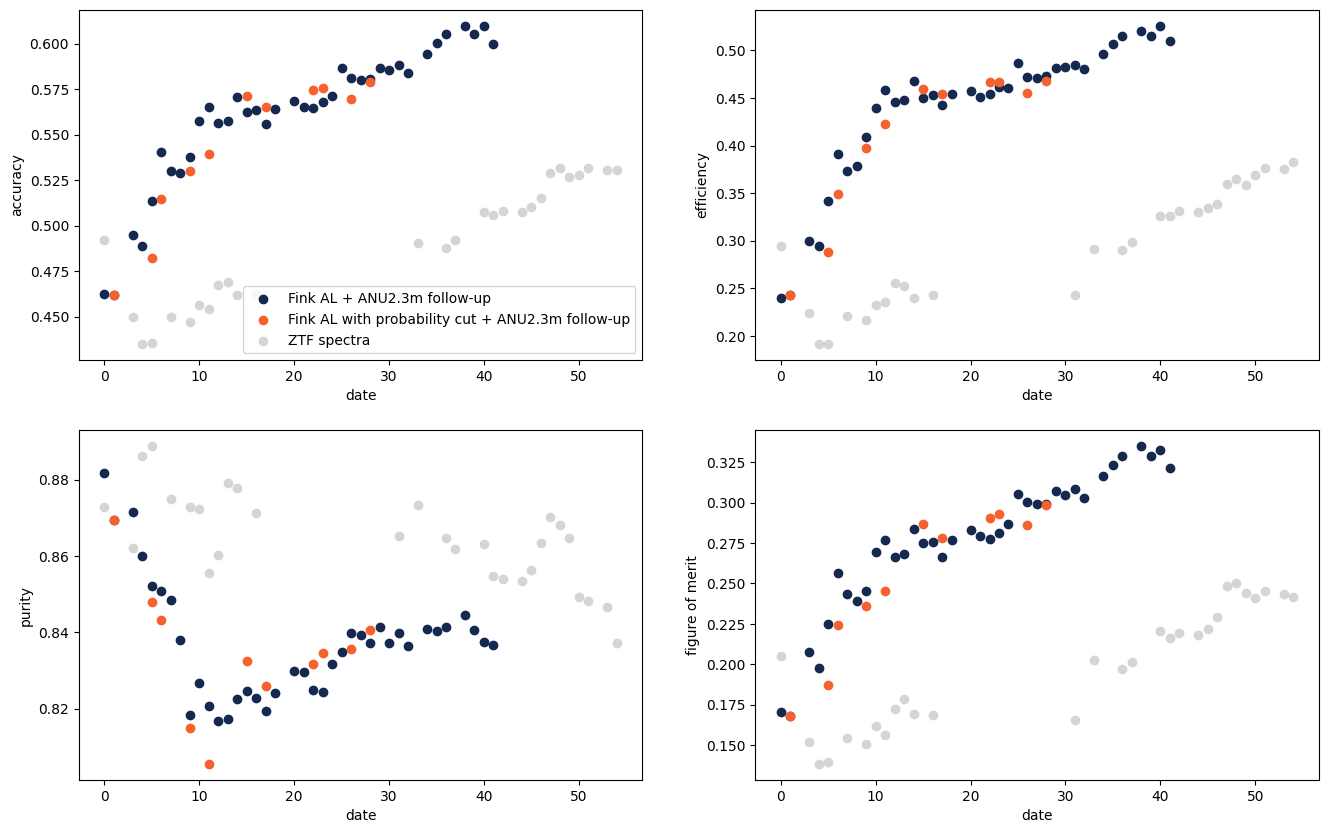

In [77]:
# not completely true as ZTF spectra dates are different than Fink AL ones
plot_metrics_listdf([metrics_fink_all,metrics_fink_probacut,metrics_ztf],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra'])

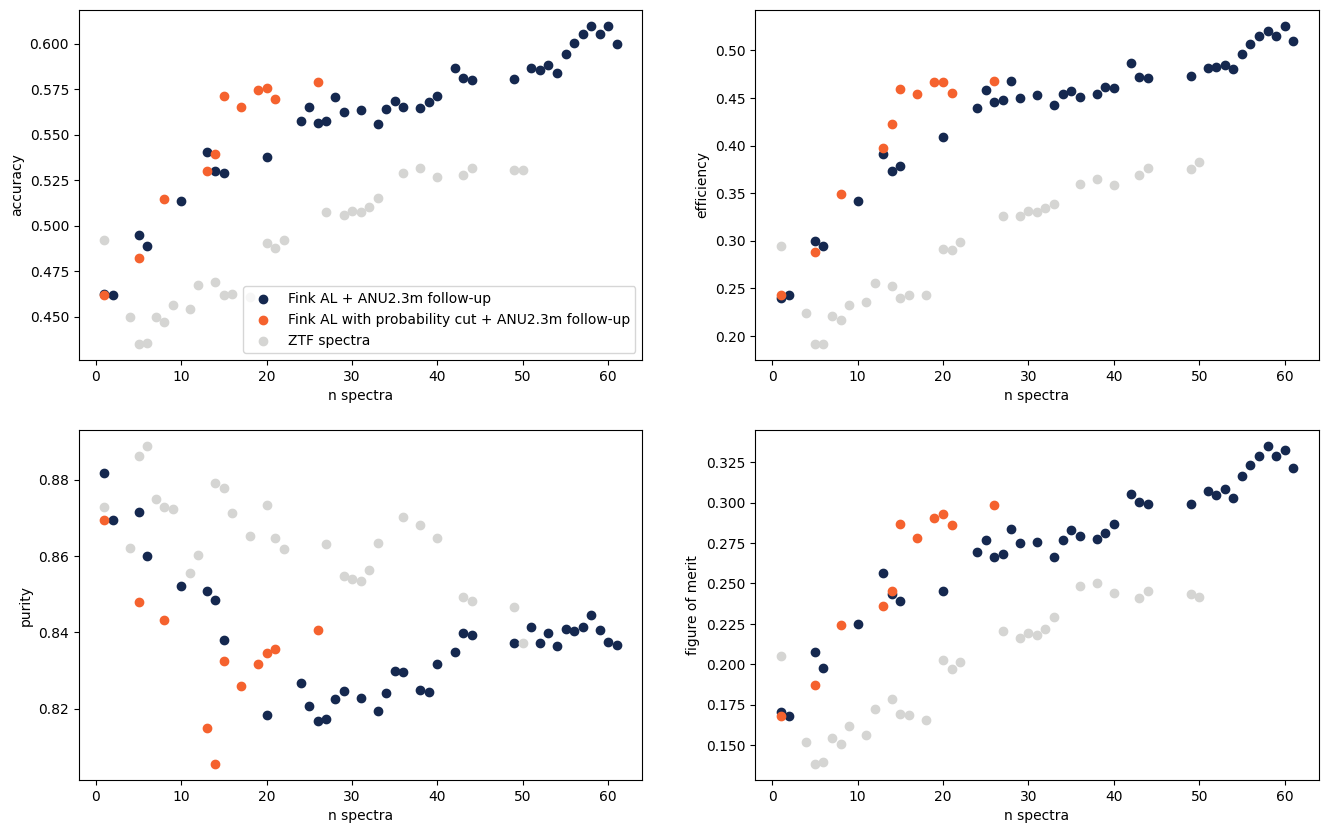

In [78]:
plot_metrics_listdf([metrics_fink_all,metrics_fink_probacut,metrics_ztf],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra'],varx='n spectra')

In [299]:
# needs manual color choice: white and grey
# plot_metrics_listdf([metrics_all_pd,metrics_probacut,metrics_ztf],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra'],varx='n spectra',suffix='onlyZTF')

# combining our tags with ZTF ones

In [235]:
# convert to new_labels format
dic_ztf_labels_all = {}

# need to use the dates that have alerts that have features
all_dates = np.concat([metrics_ztf['date'].values,metrics_fink_all['date'].values])
all_dates.sort()

for dat in all_dates: 
    # print(dat)
    try:
        tmp_arr_fink = new_labels[dat]
        # print('Fink',tmp_arr_all)
    except Exception:
        tmp_arr_fink = []
        # print('no Fink')
    
    if len(ztf_tns[ztf_tns['discoveryjd+12_strfmt']==dat])<1:
        dummy = []
        # print('No ZTF')
    
    sel = ztf_tns[ztf_tns['discoveryjd+12_strfmt']==dat]
    tmp_arr_ztf = sel[['Disc. Internal Name','type AL','discoveryjd+12']].to_numpy()

    # print('ZTF',tmp_arr_ztf)

    if len(tmp_arr_all)>0 and len(tmp_arr_fink)>0:
        # print('big combine')
        arr_out = np.concatenate([tmp_arr_ztf, tmp_arr_fink])
    elif len(tmp_arr_fink)>0:
        # print('fink')
        arr_out = tmp_arr_all
    elif len(tmp_arr_ztf)>0:
        # print('ztf')
        arr_out = tmp_arr_ztf
        
    dic_ztf_labels_all[dat] = arr_out
    

In [237]:
metrics_ztf_fink, probabilities_list_ztf_fink = AL_loop(dic_ztf_labels_all, train_for_loop, dir_suffix='ZTF_Fink', proba_cut = False)

20230921
    train_updated.shape =  (41, 15)
20230925
    train_updated.shape =  (42, 15)
20231005
    train_updated.shape =  (45, 15)
20231006
    train_updated.shape =  (46, 15)
20231009
    train_updated.shape =  (50, 15)
20231013
    train_updated.shape =  (53, 15)
20231015
    train_updated.shape =  (54, 15)
20231016
    train_updated.shape =  (56, 15)
20231018
    train_updated.shape =  (61, 15)
20231019
    train_updated.shape =  (65, 15)
20231021
    train_updated.shape =  (66, 15)
20231022
    train_updated.shape =  (67, 15)
20231025
    train_updated.shape =  (68, 15)
20231027
    train_updated.shape =  (71, 15)
20240224
    train_updated.shape =  (72, 15)
20240229
    train_updated.shape =  (73, 15)
20240404
    train_updated.shape =  (74, 15)
20240405
    train_updated.shape =  (75, 15)
20240409
    train_updated.shape =  (77, 15)
20240410
    train_updated.shape =  (79, 15)
20240412
    train_updated.shape =  (80, 15)
20240414
    train_updated.shape =  (81, 15)
20240416
 

In [238]:
# lets put the date_plot in the same baseline using the combining dataset

# mapping
to_merge = metrics_ztf_fink[['date','date_plot']]
tmp = metrics_fink_all[[k for k in metrics_fink_all.keys() if k!='date_plot']]
metrics_fink_all_tp = pd.merge(tmp, to_merge, on='date',how='left')

tmp = metrics_fink_probacut[[k for k in metrics_fink_probacut.keys() if k!='date_plot']]
metrics_fink_probacut_tp = pd.merge(tmp, to_merge, on='date',how='left')

tmp = metrics_ztf[[k for k in metrics_ztf.keys() if k!='date_plot']]
metrics_ztf_tp = pd.merge(tmp, to_merge, on='date',how='left')

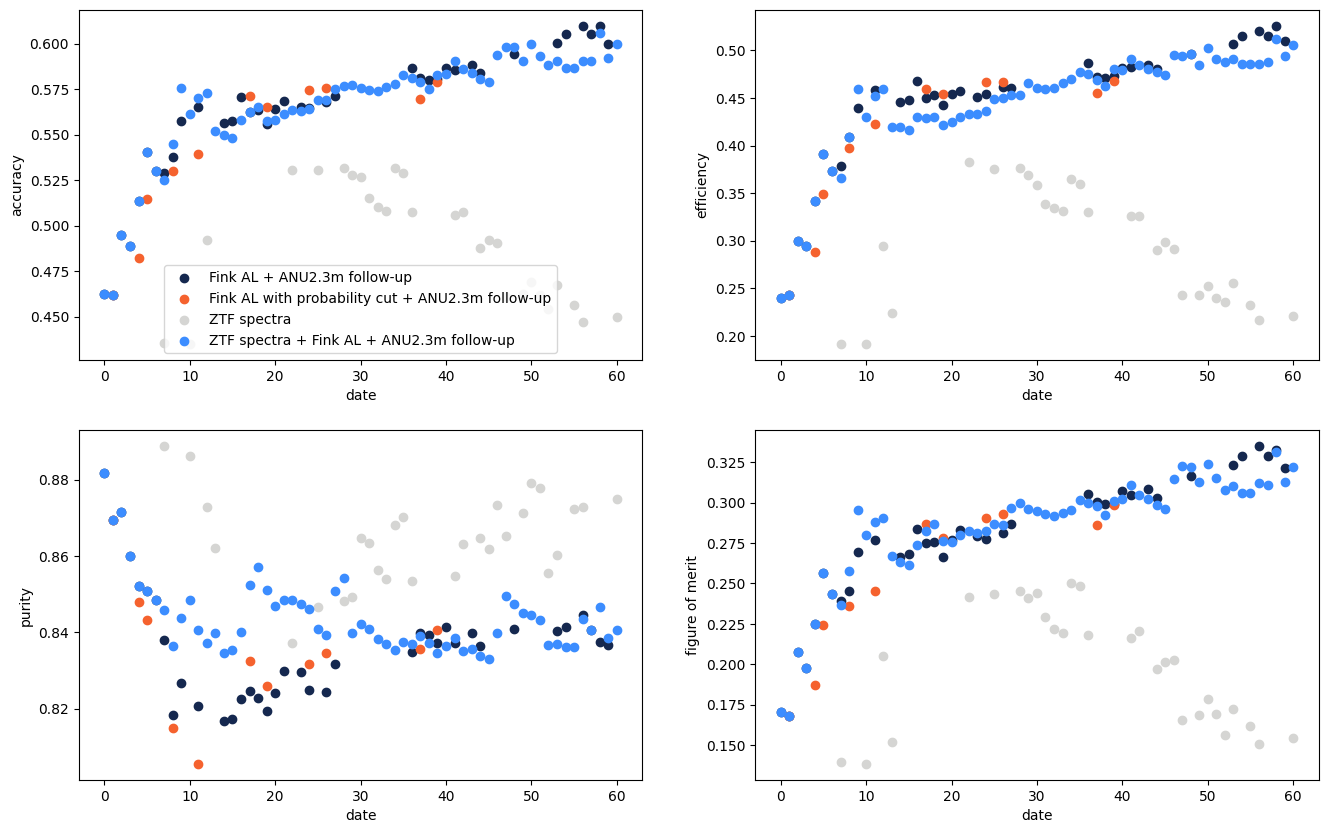

In [246]:
# for combined dates, it doesnt make sense to use the counter....
plot_metrics_listdf([metrics_fink_all_tp,metrics_fink_probacut_tp,metrics_ztf_tp,metrics_ztf_fink],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra', 'ZTF spectra + Fink AL + ANU2.3m follow-up'],suffix='mixedsamples',varx='date_plot')

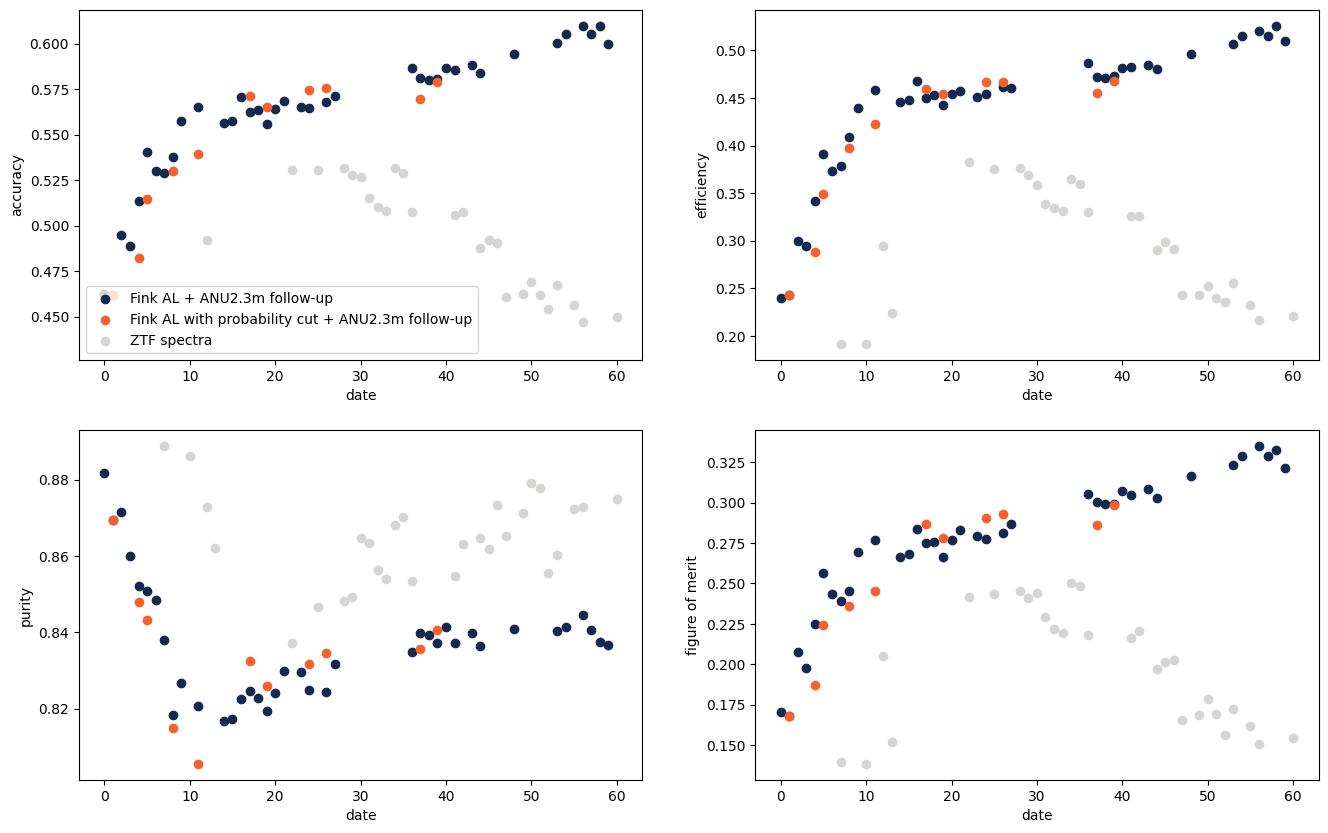

In [245]:
# for combined dates, it doesnt make sense to use the counter....
plot_metrics_listdf([metrics_fink_all_tp,metrics_fink_probacut_tp,metrics_ztf_tp],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra'],suffix='mixedsamples_gooddatecounter',varx='date_plot')

In [253]:
labels = ['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra']
for i, df in enumerate([metrics_fink_all_tp,metrics_fink_probacut_tp,metrics_ztf_tp]):
        print(df['n spectra'].max(),labels[i])

61 Fink AL + ANU2.3m follow-up
26 Fink AL with probability cut + ANU2.3m follow-up
50 ZTF spectra
